In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import importlib

In [80]:
# for debug
import jpeg_table
importlib.reload(jpeg_table)

# テーブル読み込み
TBL_L_Q = jpeg_table.table_luminance_quantization
TBL_C_Q = jpeg_table.table_chrominance_quantization
TBL_L_DC = jpeg_table.table_luminance_dc
TBL_C_DC = jpeg_table.table_chrominance_dc
TBL_L_AC = jpeg_table.table_luminance_dc
TBL_C_AC = jpeg_table.table_chrominance_ac
TBL_DCT = jpeg_table.table_dct
TBL_IDCT = jpeg_table.table_idct

In [81]:
def calc_dct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            for v in range(8):
                for u in range(8):
                    dst[v+yi, u+xi] = np.sum(src[yi:yi+8, xi:xi+8] * TBL_DCT[v, u])
    return dst

def calc_idct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            for y in range(8):
                for x in range(8):
                    dst[y+yi, x+xi] = np.sum(src[yi:yi+8, xi:xi+8] * TBL_IDCT[y, x])
    return dst

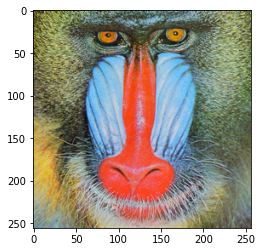

In [82]:
img_src = cv2.imread("Mandrill.bmp")
w = img_src.shape[1]
h = img_src.shape[0]
plt.imshow(img_src[:,:,::-1])

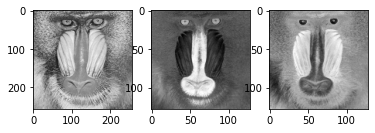

In [83]:
# YCbCr化 (色相は縮小)
img_ycrcb = cv2.cvtColor(img_src, cv2.COLOR_BGR2YCrCb)
img_y = img_ycrcb[:,:,0]
img_cr = cv2.resize(img_ycrcb[:,:,1], (w//2, h//2))
img_cb = cv2.resize(img_ycrcb[:,:,2], (w//2, h//2))

# 表示
plt.subplot(131)
plt.imshow(img_y, 'gray')
plt.subplot(132)
plt.imshow(img_cr, 'gray')
plt.subplot(133)
plt.imshow(img_cb, 'gray')

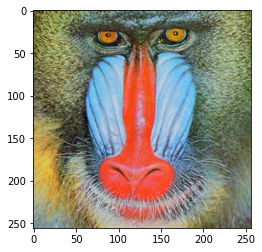

In [84]:
# dct
dct_y = calc_dct(img_y.astype(np.int32) - 128)
dct_cr = calc_dct(img_cr.astype(np.int32) - 128)
dct_cb = calc_dct(img_cb.astype(np.int32) - 128)

# test
if True:
    # 戻るかチェック
    tmp_y = np.clip(calc_idct(dct_y) + 128, 0, 255).astype(np.uint8)
    tmp_cr = np.clip(calc_idct(dct_cr) + 128, 0, 255).astype(np.uint8)
    tmp_cb = np.clip(calc_idct(dct_cb) + 128, 0, 255).astype(np.uint8)
    tmp_cr = cv2.resize(tmp_cr, (w, h))
    tmp_cb = cv2.resize(tmp_cb, (w, h))
    tmp_ycrcb = cv2.merge([tmp_y, tmp_cr, tmp_cb])
    tmp_rgb = cv2.cvtColor(tmp_ycrcb, cv2.COLOR_YCrCb2BGR)
    plt.imshow(tmp_rgb[:,:,::-1])

In [85]:
# 量子化してみる
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
        dct_y[yi:yi+8, xi:xi+8] //= TBL_L_Q
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
        dct_cr[yi:yi+8, xi:xi+8] //= TBL_C_Q
        dct_cb[yi:yi+8, xi:xi+8] //= TBL_C_Q

In [86]:
# 逆量子化してみる
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
        dct_y[yi:yi+8, xi:xi+8] *= TBL_L_Q
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
        dct_cr[yi:yi+8, xi:xi+8] *= TBL_C_Q
        dct_cb[yi:yi+8, xi:xi+8] *= TBL_C_Q

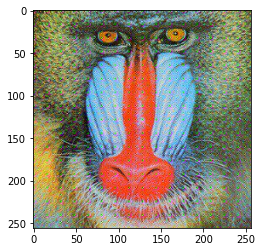

In [87]:
# 逆DCT
idct_y = np.clip(calc_idct(dct_y) + 128, 0, 255).astype(np.uint8)
idct_cr = np.clip(calc_idct(dct_cr) + 128, 0, 255).astype(np.uint8)
idct_cb = np.clip(calc_idct(dct_cb) + 128, 0, 255).astype(np.uint8)

# 色相をリサイズ
idct_cr = cv2.resize(idct_cr, (w, h))
idct_cb = cv2.resize(idct_cb, (w, h))

# 表示
idct_ycrcb = cv2.merge([idct_y, idct_cr, idct_cb])
idct_rgb = cv2.cvtColor(idct_ycrcb, cv2.COLOR_YCrCb2BGR)
plt.imshow(idct_rgb[:,:,::-1])